In [ ]:
import numpy as np

def pca(X, k):
    # Normalize the data
    mu = np.mean(X, axis=0)  # mean of the data
    s = np.std(X, axis=0, ddof=1)  # standard deviation of each coordinate
    X_norm = (X - mu) / s

    # Compute the empirical covariance matrix of the data
    m = X.shape[0]
    Sig = 1 / m * (X_norm.T @ X_norm)

    # Compute the eigenvector of Sig
    D, V = np.linalg.eig(Sig)
    I = np.argsort(np.abs(D))[::-1]  # sort the eigenvalues in descending order
    Comp = V[:, I]

    # Compute the k principal components
    U = Comp[:, :k]

    # Compute the k-dimensional representation of the data
    Z = X @ U

    return Z

def weighted_linear_regression(x, X, y, tau):
    w = 1/2 * np.exp(-np.diag((X - x) @ (X - x).T) / (2 * tau**2))
    W = np.diag(w)
    theta = np.linalg.solve(X.T @ W @ X, X.T @ W @ y)
    return theta

In [ ]:
import pandas as pd

daily_weather = pd.read_csv('datasets/daily_weather.csv', delimiter=',')
daily_weather = daily_weather.drop('(Inverters)', axis=1)

print("First five rows of daily_weather:")
print(daily_weather.head())

print("\nShape of daily_weather:")
print(daily_weather.shape)


First five rows of daily_weather:
     Date  Cloud coverage  Visibility  Temperature  Dew point   
0  2/1/16            0.10        9.45         3.11       0.32  \
1  2/2/16            0.80        3.94         6.99       6.22   
2  2/3/16            0.87        8.70         1.62       0.02   
3  2/4/16            0.37       10.00        -2.47      -5.89   
4  2/5/16            0.52        9.21        -2.00      -4.15   

   Relative humidity  Wind speed  Station pressure  Altimeter  Solar energy  
0              79.46        4.70             29.23      30.02       20256.0  
1              93.60       13.29             28.91      29.70        1761.0  
2              85.00       16.73             29.03      29.82        2775.0  
3              74.52        9.46             29.46      30.26       28695.0  
4              82.03        5.92             29.55      30.35        9517.0  

Shape of daily_weather:
(637, 10)


In [ ]:
from sklearn.model_selection import train_test_split

# Select all rows and columns except the first and last
X = daily_weather.iloc[:, 1:-1]
y = daily_weather.iloc[:, -1]

# Split the data into training, holdout, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
n = X_train.shape[1]
m_train = y_train.shape[0]
m_holdout = y_holdout.shape[0]
m_test = y_test.shape[0]

In [ ]:
# Apply PCA over the whole data set
X = np.concatenate((X_train, X_holdout, X_test), axis=0)
k = 1
Z = pca(X, k)

In [ ]:
# Split the compressed data set
Z_train = Z[:m_train, :]
Z_holdout = Z[m_train:m_train+m_holdout, :]
Z_test = Z[m_train+m_holdout:m_train+m_holdout+m_test, :]

In [ ]:
# Weighted linear regression with PCA
tau = [2, 3, 4, 10, 50, 100]
tauLegend = [f"tau = {t}" for t in tau]

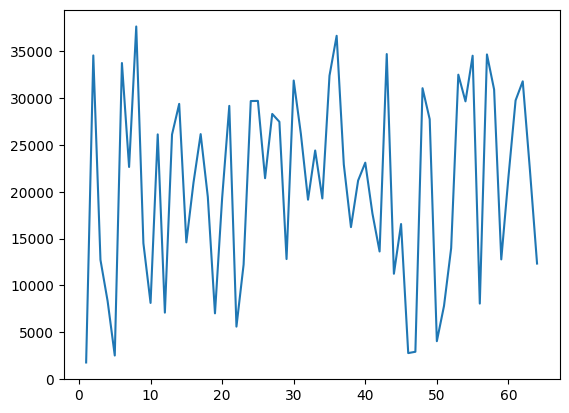

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
X_axis = np.arange(1, m_holdout+1)
plt.plot(X_axis, y_holdout, label='holdout set')

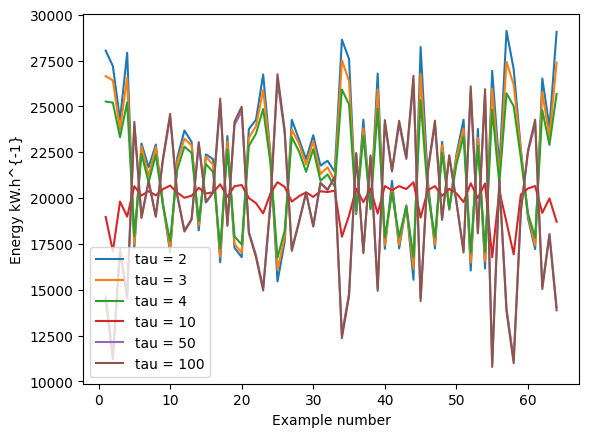

In [ ]:
holdout_error = np.ones(len(tau))
for k in range(len(tau)):
    tau_i = tau[k]
    energy_pred = np.ones(m_holdout)
    for i in range(m_holdout):
        energy_pred[i] = Z_holdout[i, :] @ weighted_linear_regression(Z_holdout[i, :], Z_train, y_train, tau_i)
    plt.plot(X_axis, energy_pred, label=f'tau = {tau_i}')
    holdout_error[k] = np.mean((y_holdout - energy_pred)**2)

plt.xlabel('Example number')
plt.ylabel('Energy kW.h^{-1}')
plt.legend()
plt.show()

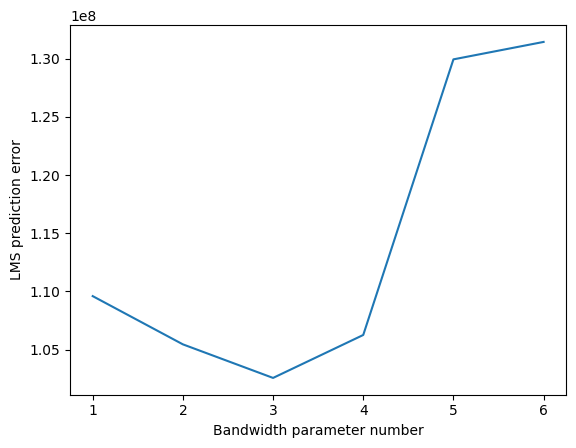

In [ ]:
# Plot the learning curve
plt.figure()
plt.plot(range(1, len(tau) + 1), holdout_error)
plt.xlabel('Bandwidth parameter number')
plt.ylabel('LMS prediction error')
plt.show()

In [ ]:
# Chosen a given value for tau
tau = 10

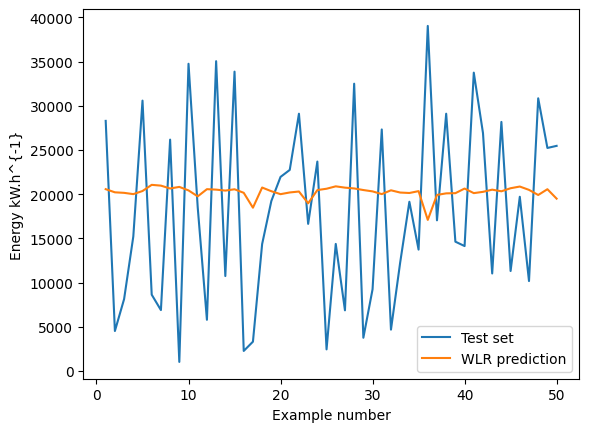

In [ ]:
plt.figure()
t = 50
X_axis = np.arange(1, t + 1)
plt.plot(X_axis, y_test[:t], label='Test set')

energy_pred = np.ones(m_test)
for i in range(m_test):
    energy_pred[i] = Z_test[i, :] @ weighted_linear_regression(Z_test[i, :], Z_train, y_train, tau)
plt.plot(X_axis, energy_pred[:t], label='WLR prediction')
plt.xlabel('Example number')
plt.ylabel('Energy kW.h^{-1}')
plt.legend()
plt.show()

In [ ]:
# Averaged LMS error
testAvgLMS = np.mean((y_test - energy_pred)**2)

print("Average LMS error for daily_weather")
print(testAvgLMS)

Average LMS error for daily_weather
125660143.10145797
